## 📘 Vectorized Forecast Patient Uptake for DrugX

#### 📌 Objective
This notebook aims to **optimize simulation performance** for multi-market patient forecasts of Drug X by implementing **vectorized versions** of simulation functions. This enables fast execution even when simulating **hundreds of iterations** across multiple countries over long time horizons (e.g., 5+ years).

I will review and organize four key functions:

1. `simulate_eligibles()`

2. `simulate_seen_by_users()`

3. `simulate_new_pts_treated()`

4. `simulate_treatment_persistence()`

All functions operate efficiently on `NumPy` arrays of shape `(n_months, n_simulations)`.

In [1]:
import numpy as np
import pandas as pd

#### 🔧 1. Simulate Monthly Eligible Patients
#### 📘 Description

This function generates a stochastic matrix of monthly eligible patients by applying:

- A **base monthly average** (`annual_eligibles / 12`)

- **Uniform random fluctuation** (±uncertainty)

- Sampling from a **Poisson distribution** for realism

✅ **Output:** Matrix of shape `(n_months, n_simulations)`

In [2]:
def simulate_eligibles(annual_eligibles, n_months, n_simulations, uncertainty=0.025):
    """
    Simulates the number of eligible patients per month over time with uncertainty, across multiple simulations.

    Parameters:
        annual_eligibles (int): The expected annual number of eligible patients.
        n_months (int): Number of months to forecast.
        n_simulations (int): Number of simulation runs.
        uncertainty (float): Proportional uncertainty applied to monthly patient incidence (default: 2.5%).

    Returns:
        np.ndarray: A (n_months, n_simulations) array of simulated eligible patients per month.
    """
    
    avg_monthly = annual_eligibles / 12
    rate_factors = np.random.uniform(1 - uncertainty, 1 + uncertainty, size=(n_months, n_simulations))
    monthly_eligibles = np.random.poisson(lam=avg_monthly * rate_factors)

    return monthly_eligibles

In [3]:
annual_eligibles = 1000
n_months = 60
fluctuation_pct = 0.025
n_simulations = 10

# testing the function
monthly_eligibles = simulate_eligibles(annual_eligibles = annual_eligibles,
                                       n_months = n_months,
                                       n_simulations = n_simulations)
monthly_eligibles[:5,:] # first 5 rows and all columns

array([[ 80,  81,  84,  83,  75,  82,  85,  65,  81,  84],
       [ 88,  86,  96,  81,  84,  85,  68,  98,  82,  79],
       [ 92,  84,  91,  96,  94,  90,  80,  70,  93,  82],
       [ 86,  88,  74,  81,  91,  87,  76,  96,  77,  68],
       [ 85,  89,  81, 107,  81,  87,  78,  92,  84,  59]])

#### 👀 2. Simulate Patients Seen by Drug X Users
#### 📘 Description
This function models how many eligible patients are **seen by users** based on:

- A **linear ramp-up** of user adoption from `initial_user_share` to `max_user_share`

- Added **random uncertainty**

- **Binomial sampling** to estimate the number seen by users

✅ Handles **month-by-month variability** and uncertainty in adoption.

In [4]:
def simulate_seen_by_users(monthly_eligibles, n_months, n_simulations,
                           initial_user_share=0.10, max_user_share=0.70,
                           share_uncertainty=0.05, months_to_peak=36):
    """
    Simulates how many eligible patients are seen by users of Drug X each month,
    based on a linear uptake of user share with uncertainty.

    Parameters:
        monthly_eligibles (np.ndarray): Array of shape (n_months, n_simulations) with eligible patients.
        n_months (int): Number of months to forecast.
        n_simulations (int): Number of simulation runs.
        initial_user_share (float): Starting proportion of users (default: 0.10).
        max_user_share (float): Maximum proportion of users reached over time (default: 0.70).
        share_uncertainty (float): Uncertainty applied to user share estimates (default: 0.05).
        months_to_peak (int): Number of months to reach maximum user share.

    Returns:
        np.ndarray: A (n_months, n_simulations) array of patients seen by users per month.
    """

    t = np.arange(n_months)
    # Linear ramp-up in user share over time
    expected_user_share = initial_user_share + (max_user_share - initial_user_share) * (t / months_to_peak)
    expected_user_share = np.clip(expected_user_share, 0, max_user_share).reshape(-1, 1)
    
    # Add uncertainty range
    p_min = np.clip(expected_user_share - share_uncertainty, 0, 1)
    p_max = np.clip(expected_user_share + share_uncertainty, 0, 1)
    
    # Sample individual probabilities for each time step and simulation
    realized_user_share = np.random.uniform(low=p_min, high=p_max, size=(n_months, n_simulations))
    # Simulate how many eligible patients are seen by users
    seen_by_users = np.random.binomial(monthly_eligibles, p=realized_user_share)

    return seen_by_users

In [5]:
initial_user_share = 0.10
max_user_share = 0.70
share_uncertainty = 0.05
months_to_peak = 36

# testing the function
seen_by_users = simulate_seen_by_users(monthly_eligibles=monthly_eligibles,
                                       n_months=n_months,
                                       n_simulations=n_simulations)
seen_by_users[:5, :]

array([[ 5,  9, 10,  5,  3,  5,  8,  3, 11, 12],
       [14, 18,  6, 11, 15, 12, 11, 12,  9,  9],
       [10, 10, 14,  8, 13,  3,  6,  6,  9, 10],
       [26, 22, 11, 24, 16, 16, 14, 14, 14,  9],
       [11, 16, 14, 23, 15, 21, 17, 20,  8, 12]])

#### 💊 3. Simulate New Patients Treated
#### 📘 Description
Estimates the number of new patients **actually treated** based on:

- `seen_by_users` matrix

- A **mean treatment probability** with added uncertainty

- **Binomial sampling** for stochasticity

✅ This mimics real-world prescription rates, including variability.

In [6]:
def simulate_new_pts_treated(seen_by_users, n_months, n_simulations,
                             mean_treatment_prob=0.25, treat_uncertainty=0.05):
    """
    Simulates how many patients are treated with Drug X each month, based on the
    number of patients seen by users and the probability to prescribe.

    Parameters:
        seen_by_users (np.ndarray): Array of shape (n_months, n_simulations) with patients seen by users.
        n_months (int): Number of months to forecast.
        n_simulations (int): Number of simulation runs.
        mean_treatment_prob (float): Average probability that a user prescribes Drug X (default: 0.25).
        treat_uncertainty (float): Uncertainty applied to the treatment probability (default: 0.05).

    Returns:
        np.ndarray: A (n_months, n_simulations) array of new patients treated with Drug X per month.
    """

    p_min = np.clip(mean_treatment_prob - treat_uncertainty, 0, 1)
    p_max = np.clip(mean_treatment_prob + treat_uncertainty, 0, 1)

    # Simulate variable prescribing probability over time and simulations
    treatment_probs = np.random.uniform(low=p_min, high=p_max, size=(n_months, n_simulations))
    new_treated = np.random.binomial(n=seen_by_users, p=treatment_probs)

    return new_treated

In [7]:
# testing the function
new_treated = simulate_new_pts_treated(seen_by_users = seen_by_users, 
                                       n_months = n_months, n_simulations = n_simulations)
new_treated[:5, :]

array([[ 3,  2,  4,  1,  1,  2,  1,  1,  2,  5],
       [ 6,  2,  1,  1,  4,  6,  4,  1,  3,  1],
       [ 3,  4,  4,  4,  1,  0,  1,  1,  1,  1],
       [10,  5,  5,  3,  3,  4,  2,  3,  3,  7],
       [ 2,  1,  4,  6,  3,  5,  2,  8,  2,  2]])

#### ⏳ 4. Simulate Treatment Persistence Over Time
#### 📘 Description
This function models how long each treated cohort **remains on treatment**, using:

- **Exponential decay** based on median persistence

- A **persistence decay matrix** applied efficiently across months

- Support for an optional **maximum treatment duration**

🔄 Loops over **start months**, not simulations – leveraging vectorization inside each decay application.

✅ **Final output:** `(n_months, n_simulations)` matrix of patients **on treatment** at each time point.

In [8]:
def simulate_treatment_persistence(new_treated, median_duration, max_duration=None):
    """
    Simulates persistence over time using exponential decay applied to a matrix of new treated patients.
    
    Parameters:
        new_treated: (n_months, n_simulations) matrix of newly treated patients
        median_duration: median number of months a patient stays on treatment
        max_duration: maximum treatment duration (cutoff)
    
    Returns:
        (n_months, n_simulations) matrix of patients on treatment at each month
    """
    n_months, n_simulations = new_treated.shape
    lambda_ = np.log(2) / median_duration  # exponential decay parameter

    # Create a persistence decay kernel matrix: shape (n_months, n_months)
    # persistence_matrix[t, d] = retention from cohort at month d, d months after treatment
    t = np.arange(n_months)
    decay_matrix = np.exp(-lambda_ * t[:, None])  # shape (n_months, 1)

    # If needed, zero out values beyond max_duration
    if max_duration is not None:
        decay_matrix[t > max_duration, :] = 0

    # Build a 3D tensor where we apply the decay for each cohort over time
    on_treatment = np.zeros_like(new_treated, dtype=float)

    for start_month in range(n_months):
        duration = n_months - start_month
        decay = decay_matrix[:duration, 0]  # decay curve for that cohort
        treated_cohort = new_treated[start_month]  # shape: (n_simulations,)
        on_treatment[start_month:start_month+duration] += decay[:, None] * treated_cohort

    return np.round(on_treatment).astype(int)

<Axes: title={'center': '10 of Monthly Forecast of Patients on Drug X per Country'}, xlabel='Months', ylabel='Nr of patients'>

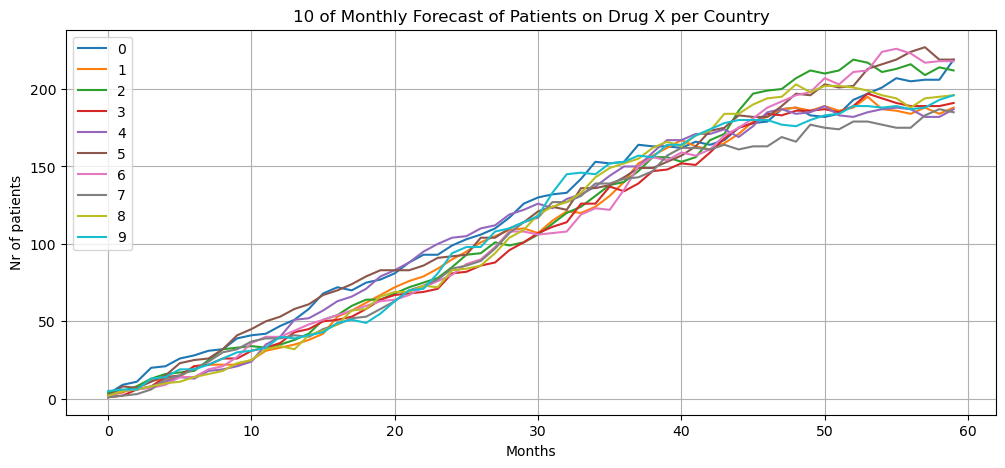

In [9]:
# testing the function
forecast = pd.DataFrame(simulate_treatment_persistence(new_treated = new_treated, median_duration = 10))
# visualizing patients on treatment per each simulation
forecast.plot(figsize=(12, 5),
             title=f"{n_simulations} of Monthly Forecast of Patients on Drug X per Country",
             ylabel='Nr of patients',
             xlabel='Months',
             grid=True)

#### 🧪 Next Steps
Now I have more efficient, vectorized implementations of the core simulation logic. From here, I can:

1. 🔁 **Loop across countries**, reusing the same structure and broadcasting inputs.

2. 🧮 **Aggregate results** (e.g., mean, percentiles) to build **best, base, worst-case scenarios**.

3. 📈 Plot **individual simulations**, **envelopes**, and **country-level totals**.